# Lecture 27: Performance of big data problems II

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1qBPclhzKTwP5E5pGrLivCHXe7LgGUP_P)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2024-01-10 00:49:08


This lecture will talk about two open-source frameworks that implement the functionality discussed in the previous one: Apache Hadoop and Apache Spark.

Both allow users to take advantage of distributed architectures for data processing.

## Hadoop

Hadoop is a framework with several components.

We will focus on two of them, which offer the features we previously discussed:

- The **Hadoop Distributed File System (HDFS)**.
- An implementation of **MapReduce**.

Together, these two let users distribute data processing across many nodes without having to worry (too much) about how files are structured or how computation is performed.

Distributed file systems share files through many storage nodes.

Instead of a single copy, each file resides in multiple copies across different parts of the system. 

- Processing tasks have access to what they might need
- Synchronization to ensure consistency
- Scalable by adding more nodes
- Resistant to failure

This type of storage is popular for big data applications.

Ideally, the user does not need to know the details of how the file system works.

To write a MapReduce application in Hadoop, a user must:

- Specify the "**mapper**" (how should a small chunk of data be processed?).
- Specify the "**reducer**" (how should the results from processing small chunks be combined?).
- Get the data onto HDFS (the cluster nodes).
- Launch the processing job by pointing to the mapper, reducer and inputs.

Hadoop takes care of the rest, like the communication between the different stages.

Very powerful for handling very large volumes of data with relative simplicity!

## Spark

Apache Spark is a framework for processing large amounts of data **in memory**.

By avoiding writing to disk unless needed, it allows repeating calculations efficiently.

It can run on top of Hadoop and take advantage of HDFS, but does not have to.

Basic features of Spark:

- **Lazy**: does not perform computations until the last moment required.
- **In-memory** processing: faster than using disk storage (but can require large RAM!).
- **Streams**: can handle data in real time as it arrives ("online").

### Spark SQL and datasets

Spark comes with interfaces in a few languages, including Python ([pyspark](https://spark.apache.org/docs/latest/api/python/getting_started/index.html)).
These offer programmatic access to its various capabilities.

The basic abstraction in Spark is a Dataset (or DataFrame). This represents a collection of items that may be distributed over multiple nodes.

DataFrames can be created by specifying the values directly, or by reading from and transforming an existing source (including a Pandas dataframe).

In [2]:
import pyspark.pandas as ps
import warnings
# Ignore FutureWarning as installed Pyspark version uses deprecated method
warnings.simplefilter(action='ignore', category=FutureWarning)

df = ps.DataFrame({
    "x": [1, 2.1, 3.5],
    "y": [2, 4.2, 7]
})

df

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/01/10 00:49:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,x,y
0,1.0,2.0
1,2.1,4.2
2,3.5,7.0


In Python, Spark DataFrames can also be handled like Panda's dataframes:

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


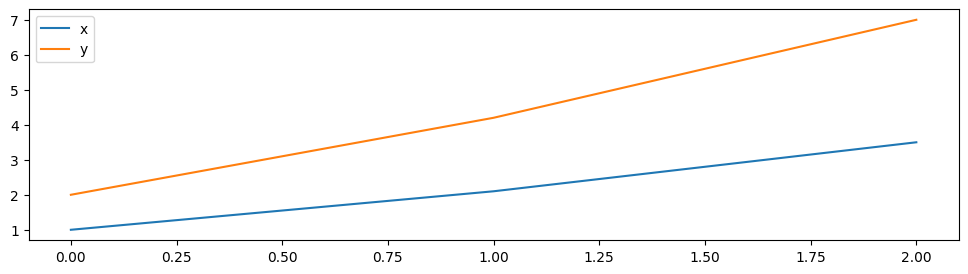

In [3]:
df.to_pandas().plot(backend="matplotlib", figsize=(12, 3));

This allows using Spark's functionality, like distributed processing, without major changes from code that originally used Pandas.

The distributed nature of the data is **transparent**: we don't need to know where it lives to work with it.

### MLib

Spark includes an extensive Machine Learning library ([MLlib](https://spark.apache.org/docs/latest/ml-guide.html)):

- Classification
- Regression
- Clustering
- Reading from different file types
- Support for ML pipelines

Working with Spark's `MLlib` allows users to take advantage of distributed architectures more easily than for example `scikit-learn`.

Get an example data file that we will use and save it in a local file

In [4]:
import urllib.request

data_url = "https://raw.githubusercontent.com/apache/spark/master/data/mllib/sample_libsvm_data.txt"
response = urllib.request.urlopen(data_url)
with open('sample_libsvm_data.txt', 'wb') as data_file:
    contents = response.read()
    data_file.write(contents)

Train a logistic regression model on the example data and print fitted parameters (adapted from the Spark documentation: https://github.com/apache/spark):

In [5]:
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
# Read in the data
training = spark.read.format("libsvm").load("sample_libsvm_data.txt" , numFeatures=692)

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print(f"Coefficients = {repr(lrModel.coefficients)}")
print(f"Intercept = {lrModel.intercept}")

Coefficients = SparseVector(692, {272: -0.0001, 300: -0.0001, 323: 0.0, 350: 0.0004, 351: 0.0003, 378: 0.0006, 379: 0.0004, 405: 0.0004, 406: 0.0008, 407: 0.0005, 428: -0.0, 433: 0.0006, 434: 0.0009, 435: 0.0001, 455: -0.0, 456: -0.0, 461: 0.0005, 462: 0.0008, 483: -0.0001, 484: -0.0, 489: 0.0005, 490: 0.0005, 496: -0.0, 511: -0.0003, 512: -0.0001, 517: 0.0005, 539: -0.0001, 540: -0.0004, 568: -0.0001})
Intercept = -0.5991460286401453


### Streaming

In many cases, it is not possible to access all the data at once, due to size or availability.

Spark allows processing data points as they arrive. It does this by creating small batches of data, calculating intermediate results, and updating those appropriately.

- Can incorporate real-time data.
- Can be more efficient when loading large datasets or from sources with high latency.
- Algorithm and program structure may need to be adapted, but Spark provides features for "hiding" that.
- For example: MLlib contains implementations for fitting on streaming training data, or making predictions on streaming unseen data.

## Summary

- Using frameworks makes it much easier to build applications with distributed data processing.
- Hadoop and Spark are complementary. Hadoop provides more basic functionality, while Spark can run standalone and is better for data that fits in memory.